## Imports

In [1]:
# standard
import numpy as np
import matplotlib.pyplot as plt

#image registration
import imreg_dft as ird

# for baseline 

from scipy.sparse import spdiags, csc_matrix
from scipy.sparse.linalg import spsolve

#for plate detection
import skimage.feature as sf
import skimage.transform as st

#for colony detection

import skimage
import scipy

#for visualisation of colonies to pick

import ipywidgets as wid

### for saving data 
import pickle

In [2]:
%matplotlib inline

## Functions

In [3]:
## converts 12 bit images to 8 bit, for plate position detection

def convert_12bit_to_8bit(image):
    
    base = image - (np.amin(image)-1) # substracts minumum value -1 from whole picture

    image8 = (np.around((255/(np.amax(base)*(1/0.9)))*base)).astype(np.uint8) # scales maximum value to 90% of 8 bit scale 
    
    return image8

In [4]:
## detects the plate by trying to fit a circle into the picture

def find_plate_coordinates(imageStack):    #,cutoff=20
    
    #edge detection in first image of stack converted to 8 bit
    
    ### values for blotting paper  !!!reasses values for new 8 bit conversion!!!
    ### edges = sf.canny(convert_12bit_to_8bit(imageStack[0]), sigma=2, low_threshold=2.5, high_threshold=3) 
    
    ### values for agar plates
    ###edges = sf.canny(convert_12bit_to_8bit(imageStack[0]), sigma=0.9, low_threshold=3, high_threshold=4) 
    edges = sf.canny(convert_12bit_to_8bit(imageStack[0]), sigma=1, low_threshold=8, high_threshold=10)
    
    #potential radii for plates, change if different plate size is used
    ### values for 80 mm blotting paper
    ### hough_radii = np.arange(480, 520, 2)
    
    ### values for petri dishes (small)
    hough_radii = np.arange(550, 600, 2)
    
    ### values for petri dishes (large)
    ### hough_radii = np.arange(600, 640, 2)
    
    #fit potential radii in edges and generate list 
    hough_res = st.hough_circle(edges, hough_radii)
    
    # empty lists for centers radii and 
    centers = []
    radii = []
    accums = []
    
    for radius, h in zip(hough_radii, hough_res):
        # For each radius, extract two circles
        num_peaks = 2
        peaks = sf.peak_local_max(h, num_peaks=num_peaks)
        centers.extend(peaks)
        accums.extend(h[peaks[:, 0], peaks[:, 1]])
        radii.extend([radius] * num_peaks)
    #get the circle with best fit 
    idx = np.argsort(accums)[::-1][:1][0]
    center_x, center_y = centers[idx]
    radius = radii[idx]                   #-cutoff  #radius minus cutoff to get rid of the rim
    
    return center_x, center_y, radius
    

In [5]:
def newMask(circle_param, w=1392, h=1040):    
    # a = x-coordinate of center of circle 
    # b = y-coordinate of center of circle 
    # r = radius of circle
    # w = width of image
    # h = hight of image
    """ This function generates a mask, that sets the area outside the plate to black. 
    Its an array of zeros the size of the picture, with a filled circle of 1's in the 
    location of the petri dish. This is done to make the colony-detection algorithm 
    work more accurately.
    """
    a,b,r = circle_param
    
    x,y = np.ogrid[-a:h-a, -b:w-b]      
    r1 = r-50       #radius of inner mask    r - 20 for blotting paper
    r2 = r-10       #radius of outer mask    r - 10 for blotting paper
    # pythagoras, generates matrix with true false if X² + Y² smaller than r², coordinates outside of circle get false
    mask_inner = x*x + y*y <= r1*r1             
    array_inner = np.zeros((h, w))
    array_inner[mask_inner] = 1
 
    mask_outer = x*x + y*y <= r2*r2             
    array_outer = np.zeros((h, w))
    array_outer[mask_outer] = 1
    
    return array_inner, array_outer

In [6]:
def applyMask(imageStack):
    #takes image stack, finds plate in first image and applies mask automatically to stack
    mask=newMask(find_plate_coordinates(imageStack))
    stackwithmask = mask * imageStack
    
    return stackwithmask

In [7]:
def trimmer(line):
    #trims zeros from the start and the end of line, gives coordinates of extracted line
    first = 0
    last = len(line)
    
    for i in line:
        if i != 0.:
            break
        else:
            first = first + 1

    for i in line[::-1]:
        if i != 0.:
            break
        else:
            last = last - 1
            
    return line[first:last], first, last

In [8]:
def baseline_maker(y,n, k, niter=10):
    #generates baseline for one-dimensional data through itterativ polynome fitting  
    #based on Eiler and Boelens 2005, Baseline correction with asymetric least squares smoothing
    # y = one-dimensional data 
    # n = exponents of the smoothness parameter lambda 
    # k = exponent of the asymetry parameter p
    # niter = number of itterations, 7 was min for typical colony data, main time consuming step
    lam = 10**n
    p = 10**k
    L = len(y)
    D = csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in xrange(niter):
        W = spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = np.array(spsolve(Z, w*y))
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [9]:
def generate_baseline(y):
    
    #trimms zeros of beginning and end, applies baseline correction and reinserts results at same position into 
    #line filled with zeros, this gets rid of edge effects, since baseline funciton is only applied to values from plate
    
    output = np.zeros(len(y), dtype="uint16")
    trimmed_line, first, last = trimmer(y)
    np.put(output,range(first,last),baseline_maker(trimmed_line,3,-3, niter=7))
    
    return output

In [10]:
def base9(imageStack):
    
    #generates baseline corrected image stack
    #baseline is calculated for every 9th line in each picture, remaining baselines are interpolated
    
    background_pic = np.empty(np.shape(imageStack))
    
    
    for i in range(len(imageStack[:])):                                                    #itterate through each picture  
                
        for n in range(0,1040,9):                                                          #itterate through each 9th line 
            background_pic[i,n] = generate_baseline(imageStack[i,n,:])                     #makes baseline
        
        for n in range(1,1036,9):                                                          #interpolates between two baselines
            background_pic[i,n]   = (8*background_pic[i,n-1] + 1*background_pic[i,n+8])/9
            background_pic[i,n+1] = (7*background_pic[i,n-1] + 2*background_pic[i,n+8])/9
            background_pic[i,n+2] = (6*background_pic[i,n-1] + 3*background_pic[i,n+8])/9
            background_pic[i,n+3] = (5*background_pic[i,n-1] + 4*background_pic[i,n+8])/9
            background_pic[i,n+4] = (4*background_pic[i,n-1] + 5*background_pic[i,n+8])/9
            background_pic[i,n+5] = (3*background_pic[i,n-1] + 6*background_pic[i,n+8])/9
            background_pic[i,n+6] = (2*background_pic[i,n-1] + 7*background_pic[i,n+8])/9
            background_pic[i,n+7] = (1*background_pic[i,n-1] + 8*background_pic[i,n+8])/9
        
        
        background_pic[i,1039] = background_pic[i,1038] = background_pic[i,1037] = background_pic[i,1036] = background_pic[i,1035]
    result_stack = imageStack - background_pic  
    
    return result_stack

In [11]:
### correct shift between 505 channel and 712 channel in a picture stack of 2 images with first being 505 and second 712

def align712to505(stack):
    ### hard coded transformation parameters 
    ### for transforming 712/30 filter into coordinates of 505/ filter
    ### avrg_parameters = {"angle" : 0.0039303334134501711, "scale" : 1.0004078664389258, 
    ###                   "tvec" : [2.2188849323118576, 8.5793525739783494]}
    
    
    avrg_parameters = {'angle': -0.020239224749644791, 'scale': 1.002176859082426,
                       'tvec': [2.3955886655092855, 9.2633606557259327]}
     
    stack[1] = ird.transform_img_dict(stack[1],avrg_parameters)
    
    return stack

In [12]:
def processStack(imageStack):
    
    ### findes plate in picture, masks out the none-plate area, applies background correction and masks out rim area of plate

    mask_inner, mask_outer = newMask(find_plate_coordinates(imageStack)) ### outer mask and inner mask are generated
    stackwithoutermask = mask_outer * imageStack
    
    backgroundCorrectedStack = base9(stackwithoutermask)
    
    resultStack = backgroundCorrectedStack * mask_inner
        
    return resultStack

In [13]:
### generates a 17 x 17 array with a 2 dimensional gausian distribution in array values, 
### which is later used as an aproximation of a colony, for template matching

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = np.meshgrid(x, y)
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel().reshape(17,17)

In [14]:
def find_colonies(image):
    
    ### defines the template which is searched in the picture, template is 2D gausian, because its similarity to a colony
    template = twoD_Gaussian((np.linspace(0, 16, 17), np.linspace(0, 16, 17)), 300, 8, 8, 3, 3, 2, 10)
    ### matches template to picture, returns array with 0-1 values depending on how closly the area looks to template kernel
    result = skimage.feature.match_template(image, template)
       
    ### creates a binary image from template-match according to threshhold  
    binaryCutOff = np.where(result > 0.65, 1, 0)
       
    ### labels each blob of 1s with a different number, outputs picture with individual blobs as number clusters,
    ### outputs also number of clusters
    label, numberOfColonies = scipy.ndimage.label(binaryCutOff)
        
    ### calculates center of mass for each cluster and saves coordinates as colonyLocation    
    colonyLocations = scipy.ndimage.measurements.center_of_mass(binaryCutOff, label, np.arange(1,numberOfColonies+1))
 


    ### generates a mask with measurement areas labeled 
    
    ### itterates trough all colonies in colonyLocations, adds off-set and places a 1 into the neares integer position in 
    ### the empty array
        
        
    AreaMask = np.zeros([1040,1392])        ### empty mask 
   
    ### colony_coordinates = []                 ### empty list for off-set-corrected colony positions
    
    for i in colonyLocations:               ### itterates through all colonies
        
        x_pos = int(round(i[0] + 8))        ### offset of 8 accounts for reduction in image size after kernel convolusion
        y_pos = int(round(i[1] + 8))        ### with template matching, template is 17/17, which shaves 8 px of the rim;
                                            ### rounds position and turns it into integer
        
        AreaMask[x_pos,y_pos] = 1           ### place 1 into center pixel of current colony in empty array
        
    ###   colony_coordinates.append((x_pos,y_pos))    ### appends coordinates of current colony                                           

    
    AreaMask = scipy.ndimage.binary_dilation(AreaMask, iterations=4)   ### dialtes colony positions to diamond shape 
    colonyAreaMask, numberOfColonies = scipy.ndimage.label(AreaMask)   ### labels diamonds with specific numbers
    
    colony_coordinates = scipy.ndimage.measurements.center_of_mass(colonyAreaMask, colonyAreaMask, np.arange(1,numberOfColonies+1))
    
    return colonyAreaMask, numberOfColonies, colony_coordinates  


In [15]:
### measures the ratio of median colony fluorescence intensity from 712 to 505 picture
### creates list with plate name colony position 505 intensity 712 intensity and ratio 712/505 for each clone 

def measure_ratio(colonyAreaMask, numberOfColonies, colony_coordinates, imageStack, plate_name, colony_data_list, plate_type):
    
    
    colonyData = np.zeros([2,numberOfColonies]) 
    
    noise = np.zeros([2,1])
    
    colonyDataMinusNoise = np.zeros([2,numberOfColonies]) 
    
    ### measures the median fluorescence of each colony 
    for i in range(len(imageStack)):
        datapoints = scipy.ndimage.median(imageStack[i,:,:], colonyAreaMask, np.unique(colonyAreaMask)[1:])    
        
        colonyData[i] = datapoints             
        
        median_noise = np.median(imageStack[i,:,:][np.nonzero(imageStack[i,:,:])])   ### median value of non zero values; all values that are on the plate
        
        MAD_noise = MAD((imageStack[i,:,:][np.nonzero(imageStack[i,:,:])]))          ### Median absolut deviation of non zero values 

        # MAD_noise_68 = 1.482602218505602 * MAD_noise                                 ### multiplied with correction factor to get to SD level, equivalent to 68% confodence interval
 
        # MAD_noise_90 = 1.645 * MAD_noise_68                                          ### multiply with correction factor to get to 90% confidence interval
                                                                                     ### 1000 colonies with 60 pixels each are equivalent to ~5% of all plate pixels
        
        noise[i] = median_noise + MAD_noise                                     ### max noise value for plate background
        
        colonyDataMinusNoise[i] = datapoints - noise[i]
    
    
    ratios = (colonyData[1]-noise[1])/(colonyData[0]-noise[0])  ### calculates the ratio between 712 channel and 505 channel 

    

    ### conglomerates all important data points for each colony
    for i in range(numberOfColonies):
                                # plate name    #plate type     #colony number  # x,y coordinates        # 505 channel                    # 712 channel              # 712/505      #505 channel minus noise      #712 channel minus noise
        colony_data_list.append((plate_name,) + (plate_type,) + (i+1,) + colony_coordinates[i] + (round(colonyData[0][i],2),) + (round(colonyData[1][i],2),) + (round(ratios[i],5),) + (round(colonyDataMinusNoise[0][i],2),) + (round(colonyDataMinusNoise[1][i],2),))
                        
    ###return colony_data_list
    

In [16]:
### calculates median absolut deviation (a robust measurement of variation)
### acording to formular: MAD = median(|Yi - Ỹ|) 

def MAD(x):
    
    median = np.median(x)                            ### median of sample
    absulut_deviations = []                          ### empty list of deviations
    
    for i in x:
        absulut_deviations.append(abs(i-median))     ### ittereates through values calculates and calculates absolut deviation to median
        
    mad = np.median(absulut_deviations)              ### calculates median of absolut deviations 
    
    return mad
    

In [17]:
### calculates modified z-score according to Iglewicz and Hoaglin (1993)
### formular: Mi = 0.6745(Yi - Ỹ)/MAD 

def mod_z_score(x):
    c = 0.67448975019608171   ### Normalization constant, is needed to adjust MAD to be like standard deviation, 
                              ### assuming normal distribution, MAD ~ 0.674*SD  
    mad = MAD(x)
    median = np.median(x)
    scores = []
    
    for i in x:
        scores.append(c*(i-median)/mad)
        
    return scores
        

## Imput

In [20]:
%%time

#### read in library plates 

folder = "" ### fill in path to raw values for plate 
names = "Example_plate_"

start_plate = 1
end_plate   = 1 

saving_path = folder + "to_pick/" + names 

compounded_data_LB = []   ### empty list for colony data 

plate_pics_505_LB = np.empty((1,1040,1392))  ### empty array for 505 pictures
plate_pics_712_LB = np.empty((1,1040,1392))  ### empty array for 712 pictures




### loops through all plates and processes them 

for i in range(start_plate,end_plate+1):
    
    plate_name = str(i)                              

    plate_type = "LB"                                  ### input plate type: LB - library,  WT - wild type 

    filename = folder + names + plate_name + ".npy"            ### generates filename
    
    data = np.load(filename)[0:2]                      ### loads numpy array which contains pictures
    
    data_aligned = align712to505(data)                 ### aligns 712 channel to 505 channel
    
    data_corrected = processStack(data_aligned)        ### finds plates, maskes out none plate space, substracts background
    
    picture_505 = np.empty((1,1040,1392))              ### new, empty 3 dimensional array for 505 picture
    picture_712 = np.empty((1,1040,1392))              ### new, empty 3 dimensional array for 712 picture
    
    picture_505[0] = data_corrected[0]                 ### 505 picture gets inserted in new array
    picture_712[0] = data_corrected[1]                 ### 712 picture gets inserted in new array
    
    plate_pics_505_LB = np.vstack([plate_pics_505_LB, picture_505])   ### 505 picture gets added to the 505 channel picture stack 
    plate_pics_712_LB = np.vstack([plate_pics_712_LB, picture_712])   ### 712 picture gets added to the 712 channel picture stack 
    
    colonyAreaMask, numberOfColonies, colony_coordinates = find_colonies(data_corrected[0])   ### identifies colonies in first picture of data stack 
    
    measure_ratio(colonyAreaMask, numberOfColonies, colony_coordinates,data_corrected,i,compounded_data_LB, plate_type)  ### measures colonies 
    
    print "done with plate " + str(i) + ", " + str(numberOfColonies) + " colonies found, " + str(len(compounded_data_LB)) + " total"  ### progress report
    
    
    
    


###Saving compiled plate pictures


np.save(saving_path + "505", plate_pics_505_LB)
np.save(saving_path + "712", plate_pics_712_LB) 

### all colony data

with open(saving_path + "colony_data.txt", "wb") as fp:
    pickle.dump(compounded_data_LB, fp)

print "done with all !"

done with plate 1, 742 colonies found, 742 total
done with all !
Wall time: 21.8 s


In [21]:
### filter out low values to prevent accidental high ratios

filtered_compounded_data_LB = []

for i in compounded_data_LB:
    if (
            i[8] > 10
        #and i[8] < 10
        and i[9] > 0 
        
        ):
        filtered_compounded_data_LB.append(i)

print str(len(compounded_data_LB)) + " clones total"        
print str(len(filtered_compounded_data_LB)) + " clones above threshold"
        

742 clones total
451 clones above threshold


In [22]:
###sort data and renove ratios below 0.1

sorted_compound_data_LB = sorted(filtered_compounded_data_LB, key=lambda x: x[7], reverse=True)

best = []

for i in filtered_compounded_data_LB:
    if i[7] > 0.1:
        best.append(i)

sorted_best_LB = sorted(best, key=lambda x: x[7], reverse=True)        
        
print str(len(best)) + " clones with ratios above 0.1"

196 clones with ratios above 0.1


In [23]:
### show top 96 values

sorted_best_LB[0:96]

[(1, 'LB', 682, 747.0, 1185.0, 38.62, 11.08, 0.26528, 32.64, 8.66),
 (1, 'LB', 707, 805.0, 1095.0, 73.8, 18.6, 0.23856, 67.82, 16.18),
 (1, 'LB', 283, 339.0, 1199.0, 42.02, 10.35, 0.22014, 36.04, 7.93),
 (1, 'LB', 661, 713.0, 1092.0, 53.04, 12.77, 0.21998, 47.07, 10.35),
 (1, 'LB', 22, 48.0, 591.0, 26.44, 6.58, 0.2035, 20.47, 4.16),
 (1, 'LB', 482, 517.0, 932.0, 66.0, 14.5, 0.20132, 60.02, 12.08),
 (1, 'LB', 492, 523.0, 1049.0, 44.67, 10.19, 0.20089, 38.69, 7.77),
 (1, 'LB', 219, 283.0, 1045.0, 80.6, 17.01, 0.19555, 74.62, 14.59),
 (1, 'LB', 406, 447.0, 1127.0, 76.33, 16.17, 0.19547, 70.36, 13.75),
 (1, 'LB', 379, 413.0, 1166.0, 34.51, 7.87, 0.19116, 28.53, 5.45),
 (1, 'LB', 549, 579.0, 1047.0, 79.87, 16.54, 0.19111, 73.89, 14.12),
 (1, 'LB', 415, 458.0, 308.0, 30.6, 7.09, 0.18962, 24.62, 4.67),
 (1, 'LB', 576, 608.0, 1068.0, 86.93, 17.44, 0.18561, 80.96, 15.03),
 (1, 'LB', 93, 145.0, 831.0, 38.8, 8.44, 0.18341, 32.82, 6.02),
 (1, 'LB', 582, 614.0, 1110.0, 48.44, 10.12, 0.18149, 42.47,

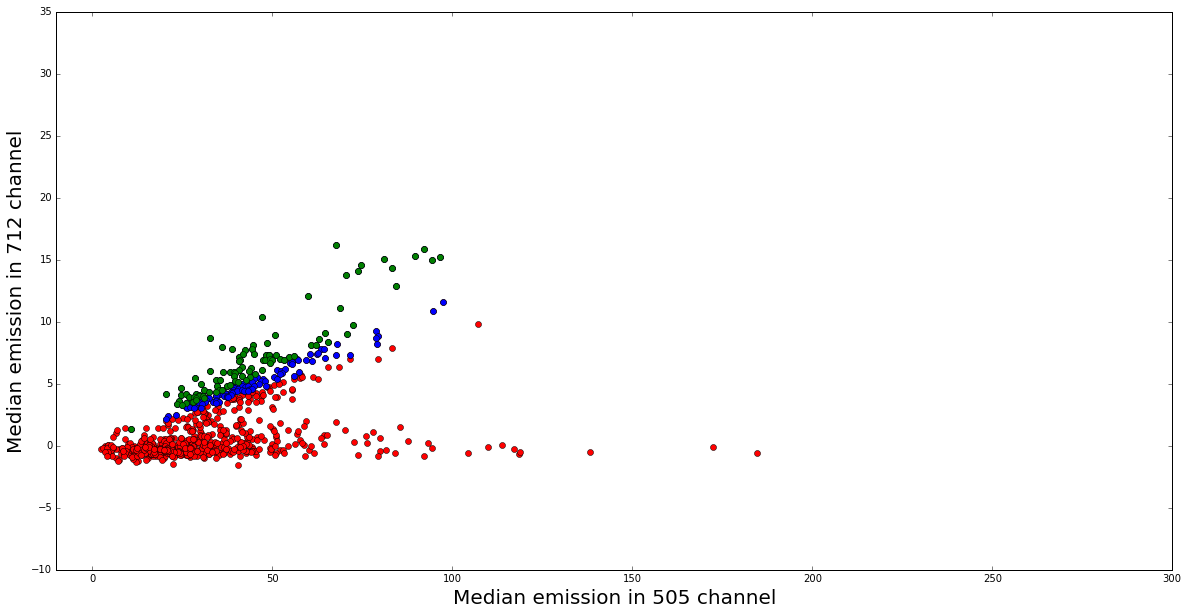

In [25]:
plt.figure(figsize=(20,10))
axes = plt.gca()
axes.set_ylim([-10,35])
axes.set_xlim([-10,300])
plt.plot([x[8] for x in compounded_data_LB],[x[9] for x in compounded_data_LB], "ro");
plt.plot([x[8] for x in sorted_best_LB],[x[9] for x in sorted_best_LB], "bo");
plt.plot([x[8] for x in sorted_best_LB[0:96]],[x[9] for x in sorted_best_LB[0:96]], "go");

plt.xlabel("Median emission in 505 channel", fontsize=20);
plt.ylabel("Median emission in 712 channel", fontsize=20);

plt.savefig("EP_colony_scatter.png", dpi=300, facecolor='w', edgecolor='w',
        papertype=None, format="png",
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)


In [ ]:
###Saving compiled plate pictures


np.save("20170721/to_pick/20170721_6A1-Lib3-175_505", plate_pics_505_LB)
np.save("20170721/to_pick/20170721_6A1-Lib3-175_712", plate_pics_712_LB)

In [21]:
###load saved plate picture files

plate_pics_505_LB = np.load("20170721/to_pick/20170721_6A1-Lib3-175_505.npy")
plate_pics_712_LB = np.load("20170721/to_pick/20170721_6A1-Lib3-175_712.npy")


In [29]:
### all colony data

with open("20170721/to_pick/20170721_6A1-Lib3-175_colony_data.txt", "wb") as fp:
    pickle.dump(compounded_data_LB, fp)

In [28]:
### load colony data 

compounded_data_LB = pickle.load(open("20170721/to_pick/20170721_6A1-Lib3-175_colony_data.txt", "rb"))


In [26]:
### inspect colonies on plate

def show_colony(number):

    colony = sorted_best_LB[number]

    plate = colony[0]

    col = colony[2]

    pics_505 = plate_pics_505_LB
    
    pics_712 = plate_pics_712_LB

    offset = 30

    for i in sorted_best_LB:
        if i[0] == plate:
            if i[2] == col: 
            

            
                plt.figure(figsize=(8.267, 6.176))
            
                plt.title('Plate: ' + str(plate));
            
                plt.plot((i[4],i[4]),(0,1040), "r")
                plt.plot((0,1392),(i[3],i[3]),"r")
                plt.imshow(pics_505[plate],cmap="Greys",vmin=0, vmax=30);
                
                plt.savefig("EP_colony_selection_1.png", dpi=300, facecolor='w', edgecolor='w',
                            papertype=None, format="png",
                            transparent=False, bbox_inches=None, pad_inches=0.1,
                            frameon=None)            
                        
            
                noise_505 = (i[5] - i[8])*  0.67448975019608171  + offset
            
            
            
                plt.figure(figsize=(8.267, 2.923))
                plt.plot(pics_505[plate][int(i[3]),:] + offset)

                plt.plot((0,1392), (noise_505,noise_505), "r")
            
                noise_712 = (i[6] - i[9]) * 0.67448975019608171
                plt.plot(pics_712[plate][int(i[3]),:])

                plt.plot((0,1392), (noise_712,noise_712), "r")
            
                plt.plot((i[4],i[4]), (-5,70))
                
                plt.savefig("EP_colony_selection_2.png", dpi=300, facecolor='w', edgecolor='w',
                            papertype=None, format="png",
                            transparent=False, bbox_inches=None, pad_inches=0.1,
                            frameon=None)             
            
                plt.figure(figsize=(8.267, 2.923))
                        
                plt.subplot(1,2,1)
                plt.plot((0,100),(50,50), "r")
                plt.plot((50,50),(0,100), "r")
                plt.imshow(pics_505[plate,int(i[3])-50:int(i[3])+50,int(i[4])-50:int(i[4])+50])
            
                plt.subplot(1,2,2)
                plt.plot((0,100),(50,50), "r")
                plt.plot((50,50),(0,100), "r")
                plt.imshow(pics_712[plate,int(i[3])-50:int(i[3])+50,int(i[4])-50:int(i[4])+50])
                
                plt.savefig("EP_colony_selection_3.png", dpi=300, facecolor='w', edgecolor='w',
                            papertype=None, format="png",
                            transparent=False, bbox_inches=None, pad_inches=0.1,
                            frameon=None) 
                
                
                print i
            
            
            

(1, 'LB', 406, 447.0, 1127.0, 76.33, 16.17, 0.19547, 70.36, 13.75)


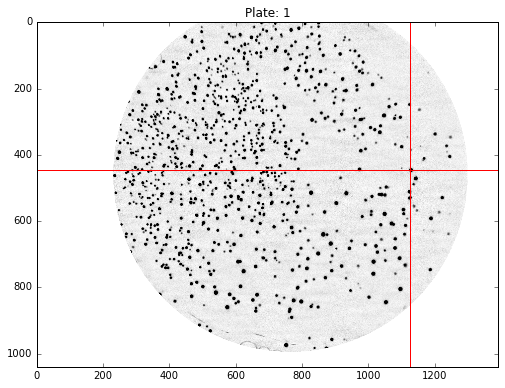

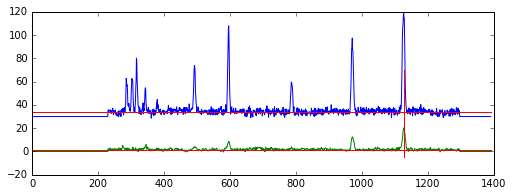

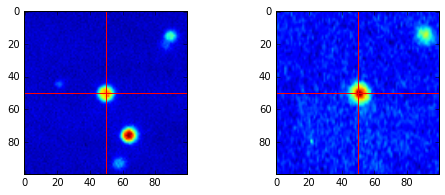

In [27]:
## interactive colony inspection on plate

wid.interact(show_colony,number = (0,20),continuous_update=False);